# Dynamic DML with Ray

This notebook compares run times for Dynamic DML with and without using Ray.

- We use examples given in [EconML notebook](https://github.com/py-why/EconML/blob/main/notebooks/Dynamic%20Double%20Machine%20Learning%20Examples.ipynb) for data generation which are used for the run time comparisons.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import time

import ray
import numpy as np
import matplotlib.pyplot as plt

import econml
from econml.panel.dml import DynamicDML
from econml.tests.dgp import DynamicPanelDGP

from sklearn.linear_model import MultiTaskLassoCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
ray.init(log_to_driver=False)
ray_opts = {'num_cpus': 2, 'scheduling_strategy': 'SPREAD'}

2024-05-28 14:55:44,029	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.23.0
Dashboard:,http://127.0.0.1:8265


In [4]:
# Define DGP parameters
np.random.seed(123)
n_panels = 7_000 # number of panels
n_periods = 3 # number of time periods in each panel
n_treatments = 2 # number of treatments in each period
n_x = 100 # number of features + controls
s_x = 10 # number of controls (endogeneous variables)
s_t = 10 # treatment support size

# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, random_seed=12345)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=12345)
data_tuple =  Y, T, X, W, groups
true_effect = dgp.true_effect

In [5]:
class TicToc:
    """Measure runtime"""
    def tic(self):
        self.start = time.time()        
        return
    
    def toc(self, minutes=False):
        runtime = time.time() - self.start
        
        if minutes:
            self.runtime = round(runtime / 60, 3)                  
            print(f"Runtime: {self.runtime} min")
        else:
            self.runtime = round(runtime, 3)                  
            print(f"Runtime: {self.runtime} sec")
            
        return self.runtime

t = TicToc()

## Output Comparison

Confirm that estimation results are identical for Ray and non-Ray versions of DynDML.


In [6]:
cv_base = 3
cv_dyn = 4

# Original implemenation without Ray
mod_baseline = DynamicDML(
    model_y = LassoCV(cv=cv_base), 
    model_t = MultiTaskLassoCV(cv=cv_base), 
    cv = cv_dyn,
    mc_iters = 2
    )

# Confirm that switch use_ray=False defaults to original implementation
mod_ray_false = DynamicDML(
    model_y = LassoCV(cv=cv_base),
    model_t = MultiTaskLassoCV(cv=cv_base),
    cv = cv_dyn,
    mc_iters = 2,
    use_ray = False,
    )

# Ray implementation
mod_ray_true = DynamicDML(
    model_y = LassoCV(cv=cv_base),
    model_t = MultiTaskLassoCV(cv=cv_base),
    cv = cv_dyn,
    mc_iters = 2,
    use_ray = True,
    ray_remote_func_options = ray_opts
    )

In [7]:
t.tic()
mod_baseline.fit(Y, T, X=None, W=W, groups=groups)
_ = t.toc()

t.tic()
mod_ray_false.fit(Y, T, X=None, W=W, groups=groups)
_ = t.toc()

t.tic()
mod_ray_true.fit(Y, T, X=None, W=W, groups=groups)
_ = t.toc()

Runtime: 36.556 sec


Runtime: 43.683 sec


Runtime: 25.164 sec


In [8]:
# Confirm that point estimates identical
assert np.all(mod_baseline.const_marginal_ate() == mod_ray_false.const_marginal_ate())
assert np.all(mod_baseline.const_marginal_ate() == mod_ray_true.const_marginal_ate())

# Confirm that CIs identical
assert np.all(mod_baseline.const_marginal_ate_interval()[0] == mod_ray_false.const_marginal_ate_interval()[0])
assert np.all(mod_baseline.const_marginal_ate_interval()[1] == mod_ray_false.const_marginal_ate_interval()[1])
assert np.all(mod_baseline.const_marginal_ate_interval()[0] == mod_ray_true.const_marginal_ate_interval()[0])
assert np.all(mod_baseline.const_marginal_ate_interval()[1] == mod_ray_true.const_marginal_ate_interval()[1])


In [9]:
# Compare estimation results
mod_baseline.summary()
mod_ray_false.summary()
mod_ray_true.summary()


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,0.056,0.035,1.598,0.11,-0.013,0.124
cate_intercept|(T1)$_0$,0.118,0.034,3.482,0.0,0.052,0.184
cate_intercept|(T0)$_1$,0.293,0.03,9.669,0.0,0.233,0.352
cate_intercept|(T1)$_1$,0.213,0.03,6.98,0.0,0.153,0.272
cate_intercept|(T0)$_2$,0.132,0.002,54.326,0.0,0.127,0.137
cate_intercept|(T1)$_2$,0.606,0.002,250.606,0.0,0.602,0.611


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,0.056,0.035,1.598,0.11,-0.013,0.124
cate_intercept|(T1)$_0$,0.118,0.034,3.482,0.0,0.052,0.184
cate_intercept|(T0)$_1$,0.293,0.03,9.669,0.0,0.233,0.352
cate_intercept|(T1)$_1$,0.213,0.03,6.98,0.0,0.153,0.272
cate_intercept|(T0)$_2$,0.132,0.002,54.326,0.0,0.127,0.137
cate_intercept|(T1)$_2$,0.606,0.002,250.606,0.0,0.602,0.611


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,0.056,0.035,1.598,0.11,-0.013,0.124
cate_intercept|(T1)$_0$,0.118,0.034,3.482,0.0,0.052,0.184
cate_intercept|(T0)$_1$,0.293,0.03,9.669,0.0,0.233,0.352
cate_intercept|(T1)$_1$,0.213,0.03,6.98,0.0,0.153,0.272
cate_intercept|(T0)$_2$,0.132,0.002,54.326,0.0,0.127,0.137
cate_intercept|(T1)$_2$,0.606,0.002,250.606,0.0,0.602,0.611


## Runtime Comparison: Linear Models

In [10]:
def runtime_comparisons(data_tuple, model_y, model_t, cv_list, vary_base_cv=False, use_ray=False, ray_opts=False):

    Y, T, X, W, groups = data_tuple

    runtime_list = []
    model_list = []

    for cv in cv_list:

        if vary_base_cv:
            try: 
                model_y.cv = cv
                print(f"Setting model_y cv={cv}")
            except AttributeError:
                print("Model y has no attribute cv")
            
            try: 
                model_t.cv = cv
                print(f"Setting model_t cv={cv}")
            except AttributeError:
                print("Model t has no attribute cv")      

        if use_ray:
            model = DynamicDML(
                model_y = model_y,
                model_t = model_t,
                cv = cv,
                use_ray = True,
                ray_remote_func_options = ray_opts
                )

        else:
            model = DynamicDML(
                model_y = model_y, 
                model_t = model_t, 
                cv = cv)

        t.tic()
        model.fit(Y=Y, T=T, X=X, W=W, groups=groups)
        
        runtime_list.append(t.toc())
        model_list.append(model)

    return runtime_list, model_list


def test_result_equivalence(model_list_0, model_list_1, model_list_2=None):
    """Test whether estimation results the same for Ray and non-Ray implementations."""
    
    assert len(model_list_0) == len(model_list_1)

    if isinstance(model_list_2, list):
        assert len(model_list_0) == len(model_list_2)

    for k in range(0, len(model_list_0)):

        # Confirm that point estimates identical
        assert np.all(model_list_0[k].const_marginal_ate() == model_list_1[k].const_marginal_ate())
                
        # Confirm that CIs identic[k]al
        assert np.all(model_list_0[k].const_marginal_ate_interval()[0] == model_list_1[k].const_marginal_ate_interval()[0])
        assert np.all(model_list_0[k].const_marginal_ate_interval()[1] == model_list_1[k].const_marginal_ate_interval()[1])

        if isinstance(model_list_2, list):
            assert np.all(model_list_0[k].const_marginal_ate() == model_list_2[k].const_marginal_ate())
            assert np.all(model_list_0[k].const_marginal_ate_interval()[0] == model_list_2[k].const_marginal_ate_interval()[0])
            assert np.all(model_list_0[k].const_marginal_ate_interval()[1] == model_list_2[k].const_marginal_ate_interval()[1])
    
    return


In [11]:
ray_opts = {'num_cpus': 2, 'scheduling_strategy': 'SPREAD'}

cv_list = [2, 4, 8, 10]

model_y = LassoCV()
model_t = MultiTaskLassoCV()

print("Estimating without Ray...")
runtimes_baseline, models_baseline = runtime_comparisons(data_tuple,
                                                         model_y,
                                                         model_t,
                                                         cv_list,
                                                         vary_base_cv=True,
                                                         use_ray=False)

print("\nEstimating with Ray...")
runtimes_ray, models_ray = runtime_comparisons(data_tuple,
                                               model_y,
                                               model_t,
                                               cv_list,
                                               vary_base_cv=True,
                                               use_ray=True,
                                               ray_opts=ray_opts)

test_result_equivalence(models_baseline, models_ray)

Estimating without Ray...
Setting model_y cv=2
Setting model_t cv=2
Runtime: 5.695 sec
Setting model_y cv=4
Setting model_t cv=4
Runtime: 18.632 sec
Setting model_y cv=8
Setting model_t cv=8
Runtime: 36.639 sec
Setting model_y cv=10
Setting model_t cv=10
Runtime: 45.896 sec

Estimating with Ray...
Setting model_y cv=2
Setting model_t cv=2
Runtime: 3.786 sec
Setting model_y cv=4
Setting model_t cv=4
Runtime: 9.034 sec
Setting model_y cv=8
Setting model_t cv=8
Runtime: 22.37 sec
Setting model_y cv=10
Setting model_t cv=10
Runtime: 25.48 sec


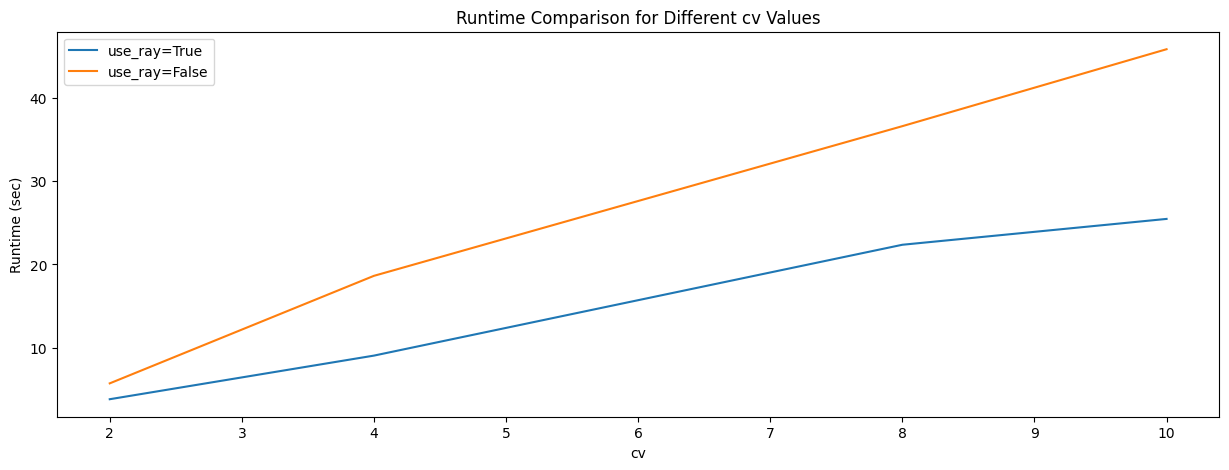

In [12]:
_ = plt.figure(figsize=(15, 5))
_ = plt.plot(cv_list, runtimes_ray, label='use_ray=True')
_ = plt.plot(cv_list, runtimes_baseline, label='use_ray=False')
_ = plt.xlabel('cv')
_ = plt.ylabel('Runtime (sec)')
_ = plt.title('Runtime Comparison for Different cv Values')
_ = plt.legend()
plt.show()

## Runtime Comparison: Tree-Based Methods

In [13]:
# Define DGP parameters
np.random.seed(123)
n_panels = 1_000 # number of panels
n_periods = 3 # number of time periods in each panel
n_treatments = 1 # number of treatments in each period
n_x = 20 # number of features + controls
s_x = 5 # number of controls (endogeneous variables)
s_t = 5 # treatment support size

# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, random_seed=12345)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=12345)
data_tuple =  Y, T, X, W, groups
true_effect = dgp.true_effect


In [14]:
ray_opts = {'num_cpus': 2, 'scheduling_strategy': 'SPREAD'}  # Run times similar if we set `num_cpus : os.cpu_count()` 

cv_list = [2, 4, 8, 10]

model_y = RandomForestRegressor(random_state=123)
model_t = RandomForestRegressor(random_state=123)

print("Estimating without Ray...")
runtimes_baseline, models_baseline = runtime_comparisons(data_tuple,
                                                         model_y,
                                                         model_t,
                                                         cv_list,
                                                         vary_base_cv=False,
                                                         use_ray=False)

print("\nEstimating with Ray...")
runtimes_ray, models_ray = runtime_comparisons(data_tuple,
                                               model_y,
                                               model_t,
                                               cv_list,
                                               vary_base_cv=False,
                                               use_ray=True,
                                               ray_opts=ray_opts)

test_result_equivalence(models_baseline, models_ray)

Estimating without Ray...
Runtime: 7.25 sec
Runtime: 23.175 sec
Runtime: 55.801 sec
Runtime: 71.653 sec

Estimating with Ray...
Runtime: 3.85 sec
Runtime: 6.425 sec
Runtime: 15.181 sec
Runtime: 18.523 sec


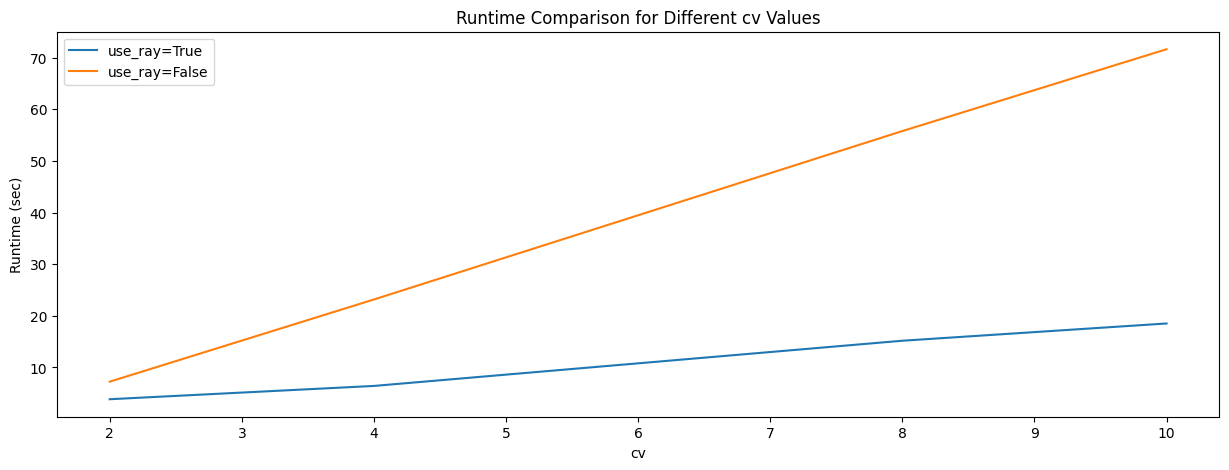

In [15]:
_ = plt.figure(figsize=(15, 5))
_ = plt.plot(cv_list, runtimes_ray, label='use_ray=True')
_ = plt.plot(cv_list, runtimes_baseline, label='use_ray=False')
_ = plt.xlabel('cv')
_ = plt.ylabel('Runtime (sec)')
_ = plt.title('Runtime Comparison for Different cv Values')
_ = plt.legend()
plt.show()

In [20]:
ray_opts = {'num_cpus': 2, 'scheduling_strategy': 'SPREAD'}

cv_list = [2, 4, 8, 10]

model_y = xgb.XGBRegressor(seed=123)
model_t = xgb.XGBRegressor(seed=123)

print("Estimating without Ray...")
runtimes_baseline, models_baseline = runtime_comparisons(data_tuple,
                                                         model_y,
                                                         model_t,
                                                         cv_list,
                                                         vary_base_cv=False,
                                                         use_ray=False)

print("\nEstimating with Ray...")
runtimes_ray, models_ray = runtime_comparisons(data_tuple,
                                               model_y,
                                               model_t,
                                               cv_list,
                                               vary_base_cv=False,
                                               use_ray=True,
                                               ray_opts=ray_opts)

test_result_equivalence(models_baseline, models_ray)


Estimating without Ray...
Runtime: 3.501 sec
Runtime: 7.043 sec
Runtime: 12.311 sec
Runtime: 17.368 sec

Estimating with Ray...
Runtime: 1.291 sec
Runtime: 2.068 sec
Runtime: 3.849 sec
Runtime: 5.018 sec


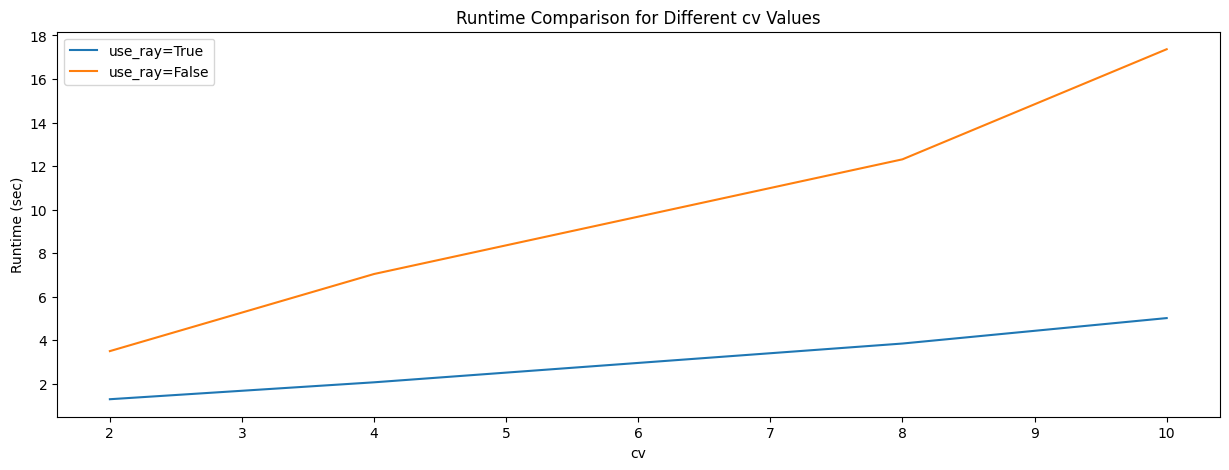

In [21]:
_ = plt.figure(figsize=(15, 5))
_ = plt.plot(cv_list, runtimes_ray, label='use_ray=True')
_ = plt.plot(cv_list, runtimes_baseline, label='use_ray=False')
_ = plt.xlabel('cv')
_ = plt.ylabel('Runtime (sec)')
_ = plt.title('Runtime Comparison for Different cv Values')
_ = plt.legend()
plt.show()